# Lecture 22: Data Pipelines

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1rhbgAij_4MaujlsdQ8mBjSKXrVhaq9e_)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2024-05-15 18:45:28


Applying machine learning algorithms and approaches to real-world data
involves a number of practical challenges. In this series of lectures,
we will look at tools and ways of working that address questions like:

- How can I store and access large amounts of data remotely?
- How can I keep track of different versions of datasets?
- How can I share my results and make my analyses reproducible by others?

Before we get into individual questions, let's take a look at the broader picture of how we handle data, before and after running any analysis or inference methods.

## Pipelines

More often than not, the data of interest will not be in a directly useable form, or perhaps not even immediately available to you.

Before we can train any model, we first need to make sure that the data is available and properly formatted. This can involve a number of steps:

- Accessing the data
- Cleaning and other preprocessing
- Transforming and generating features
- Making the data available to the model

After this, the data is ready to be used in our algorithm of choice.

<img alt="Image of a data pipeline comprising the steps of accessing, preproessing, transforming, serving, modelling and publishing data. Each step is represented as a box with arrows linking them" src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture22_Images/pipeline.svg" width="100%" />

This sequence of steps is sometimes called a **data pipeline**. Another related term used to describe similar workflows is ETL: Extract-Transform-Load.

When possible, it is useful to perform these steps programmatically (through code) rather than manually.

## Accessing data

If we haven't collected the data ourselves, we will first need to get our (virtual) hands on it! This can be done in a number of ways. For example:

- A colleague gives us a file
- We connect to a web service that produces the data
- We "scrape" a web page or other source to extract the data ourselves
- We query a database for the particular data we want

Sometimes we will need to combine more than one source to get the full set of data that we require.

We will talk more about databases in a subsequent lecture. 

A common element in the above examples is that the data can exist in some **remote** location. How we get it on our own computer will depend on the source, format and size of the data. However, this can often be done programmatically.

### Example: Downloading climate data

Simple Storage Service (S3) is a storage service offered by Amazon Web Services (AWS). Users can upload datasets which can then be accessed by others. As a running example we will look at an [open dataset of historical global climate records](https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-ghcn) assembled by the _National Oceanic and Atmospheric Adminstration_ that can be downloaded by anyone.

To run this example locally, you will need to install [the Python package `boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), which will let you communicate with AWS.

We download climate records for the year 1800 from a AWS S3 bucket `noaa-ghcn-pds`. The data is stored as a comma separated variable (CSV) file compressed using [gzip](https://en.wikipedia.org/wiki/Gzip). We use the `gzip` module in the Python standard library to uncompress the file and Pandas to read the CSV data to a dataframe.

In [2]:
import boto3
from botocore import client, UNSIGNED
import gzip
import pandas

client = boto3.client('s3', config=client.Config(signature_version=UNSIGNED))
response = client.get_object(Bucket="noaa-ghcn-pds", Key="csv.gz/1800.csv.gz")
with gzip.open(response['Body'], "rb") as f:
    input_data = pandas.read_csv(f, usecols=range(4), names=["station", "date", "quantity", "value"])
display(input_data.head())

,station,date,quantity,value
0,EZE00100082,18000101,TMAX,-86
1,EZE00100082,18000101,TMIN,-135
2,GM000010962,18000101,PRCP,0
3,ITE00100554,18000101,TMAX,-75
4,ITE00100554,18000101,TMIN,-148


## Preprocessing

Getting hold of the data you want to work with is only the first step. Sometimes this raw or preliminary data has to be changed. There are many reasons why:

- Data may contain errors
- Dimensionality or size of dataset is too high
- We want to focus only on a subset of interest
- Raw data does not directly contain variables of interest 
- Some algorithms are negatively impacted by e.g. imbalances in class frequencies or extreme values

Preprocessing steps can include:
- Replacing values that are incorrect or cause problems
- Filtering, subsampling (discarding samples) or supersampling (repeating samples)
- Removing outliers

Aspects of this are often referred to as **"cleaning"** the data. This is an important and often undervalued step in the pipeline. These transformations can be performed manually, although tools like [OpenRefine](https://openrefine.org/) can simplify and automate the process.

## Example: filtering climate records for a specific station

Continuing with the climate data example, the dataframe `input_data` we loaded contains climate records for multiple different land-observation stations. We might wish to fit a model to the daily extreme temperature records for a single station and so need to filter the input data to leave only the temperature measurements associated with this station. Using station `ITE00100554` (in Milan, Italy) as an example we can achieve this for example using [the `DataFrame.query` method in Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

In [3]:
preprocessed_data = input_data.query('station == "ITE00100554" and quantity in ["TMIN", "TMAX"]')
display(preprocessed_data.head())

,station,date,quantity,value
3,ITE00100554,18000101,TMAX,-75
4,ITE00100554,18000101,TMIN,-148
8,ITE00100554,18000102,TMAX,-60
9,ITE00100554,18000102,TMIN,-125
13,ITE00100554,18000103,TMAX,-23


## Transforming

Cleaning brings you one step closer to useable data inputs for your model. However, your analysis may rely on variables that are not directly present in the original data.

There is therefore a need for **feature generation**: extracting the variables of interest by combining existing ones.

## Example: transforming to temperature range time series

The `preprocessed_data` dataframe we computed previously contains rows with individual `TMIN` and `TMAX` measurements (daily minimum and maximum temperatures in tenths of a degree Celsius) for each day in 1800. If we wish to fit a regression model of the daily _temperature range_ in degrees Celsius against the date we need to transform the data in the `preprocessed_data` dataframe accordingly.

In [4]:
pivotted_data = preprocessed_data.pivot(index="date", columns="quantity", values="value")
pivotted_data.index = pandas.to_datetime(pivotted_data.index, format="%Y%m%d")
transformed_data = pandas.DataFrame({"temperature_range": (pivotted_data.TMAX - pivotted_data.TMIN) / 10})
display(transformed_data.head())

,temperature_range
date,
1800-01-01,7.3
1800-01-02,6.5
1800-01-03,2.3
1800-01-04,1.3
1800-01-05,1.6


## Serving

The code you have written may expect to read in data in a particular format, such as a CSV file, or a collection of files. The result of your preprocessing must therefore be made available in the same format.

<img alt="Diagram of a format mismatch between a data source and model" src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture22_Images/mismatch.svg" width="70%" />

Note that the result of this step need not be a file on your computer: you could choose to serve your data through, for example, a web service. The important thing is that, at the end of this step, the data is ready to be fed into the model, matching what that code expects.

This preparation can often be done through a library. For instance, `pandas` offers several methods for writing out a data frame to a number of commonly-used formats:

```python
import pandas as pd
df = pd.read_json('my_data.json')
# ...Perform any transformations...
df.to_csv('my_ready_data.csv')
```

## Example: serving features and targets for scikit-learn

As seen in a previous lecture, scikit-learn models expect the training data for regression problems to be formatted as a _features matrix_ with each row corresponding to the (numeric) features for each training datapoint and a _target array_, a one-dimensional array containing the target values for each training datapoint.

Here we use the measurement dates converted to integer days of the year as the input features and the temperature ranges as the target values.

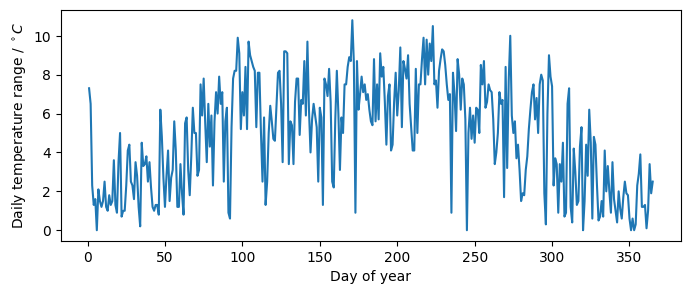

In [5]:
import matplotlib.pyplot as plt

X_train = transformed_data.index.day_of_year.array[:, None]
y_train = transformed_data.temperature_range.array
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_train, y_train)
ax.set(xlabel="Day of year", ylabel="Daily temperature range / $^\circ C$");

## Model fitting

Once we have our data in the expected format we can fit a model using any of the various approaches and Python packages seen in the previous lectures - for example scikit-learn or TensorFlow.

Note that both scikit-learn and TensorFlow themselves use data pipelines concept as an abstraction when building models - see for example the [scikit-learn documentation for the `Pipeline` class](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). When we refer to 'a model' we therefore are often actually referring to something that is itself a composition of multiple components, including steps we might consider as preprocessing or transforming. The boundaries between the model and other stages in the pipeline we have described in reality may not always be as clear cut as in our simple flowchart.

## Example: fitting a periodic spline with scikit-learn

We can fit a [spline model](https://en.wikipedia.org/wiki/Spline_(mathematics)) using scikit-learn to smoothly interpolate our running example dataset. As we have time series data of daily temperature ranges for a full year and we would expect the dominant trends to be seasonal in nature we will enforce that the fitted model is periodic. We fit a cubic spline with seven knots at roughly bimonthly intervals so that we capture a smooth representation of the overall seasonal trends rather than the noisy daily variation.

In [6]:
import numpy
from sklearn import pipeline, preprocessing, linear_model

knots = numpy.linspace(1, 365, 7)[:, None]
model = pipeline.make_pipeline(
    preprocessing.SplineTransformer(degree=3, knots=knots, extrapolation="periodic"),
    linear_model.Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(extrapolation='periodic',
                                   knots=array([[  1.        ],
       [ 61.66666667],
       [122.33333333],
       [183.        ],
       [243.66666667],
       [304.33333333],
       [365.        ]]))),
                ('ridge', Ridge())])

We can visualise the fitted model's predictions over the input range to check they look reasonable using `matplotlib`

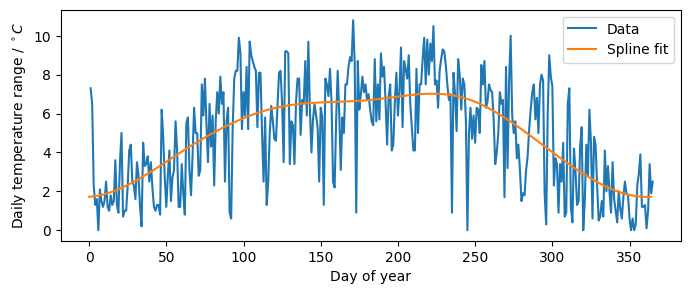

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_train, y_train, model.predict(X_train))
ax.set(xlabel="Day of year", ylabel="Daily temperature range / $^\circ C$")
ax.legend(["Data", "Spline fit"]);

## Publishing

The lifecycle of data does not have to end when you feed it into a model!

You can even think of the model itself, and any analyses (e.g. predictions) you make based on it, as new data. These can in turn be made available to support further research or other work.

You may want to consider uploading them to cloud storage (like S3) or a provider like [Zenodo](https://zenodo.org/).

### Publishing data
When releasing your datasets, it is useful to put them in a standard format (such as CSV or JSON) that will be easy for others to read. You should also include **metadata** that explains how the data was generated and what it contains.

The [**FAIR principles**](https://www.go-fair.org/fair-principles/) are a guide for sharing research data outputs. They encourage you to ensure that your data is:
- Findable: users must be able to search for the data somewhere
- Accessible: users must know how to access them (ideally automatically)
- Interoperable: the data can "work" together with other data or applications
- Reusable: it is clear how to use the data, including its structure, format, and any conditions (licence)

### Publishing models
Sharing the model itself is less straightforward, but there are still ways that you can make it available. You could:
- build an executable application that you can distribute for people to run
- create a web service that people can call with their own data to get your trained model's outputs
- create a **container** (for use with e.g. Docker), a reusable image of your application and its dependencies that others can run on their machine
- **serialize** the model and share it as a text file

Serialization (converting the trained model code into a string which can be loaded and executed) is perhaps the simplest but is not always trivial.

Fortunately, Python's [`pickle`](https://docs.python.org/3/library/pickle.html) library can serialize a range of objects, including scikit-learn models, allowing you to [store and share trained models as static files](https://scikit-learn.org/stable/modules/model_persistence.html).

In [8]:
import pickle

with open("trained_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("trained_model.pkl", "rb") as f:
    saved_model = pickle.load(f)
saved_model

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(extrapolation='periodic',
                                   knots=array([[  1.        ],
       [ 61.66666667],
       [122.33333333],
       [183.        ],
       [243.66666667],
       [304.33333333],
       [365.        ]]))),
                ('ridge', Ridge())])

## Summary
- Data needs to go through a number of steps before it can used in a model.
- Doing this process programmatically, not manually, leaves a record and facilitates repetition and verification.
- Remote access to data is becoming increasingly important as size grows.